In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn, distributions
from torch.func import vmap, jacrev
from torch.autograd import functional

from typing import Callable
from tqdm import tqdm

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_num_threads(16)

In [3]:
class ObservableSystem:
    transition: Callable[[torch.Tensor], torch.Tensor]
    observation: Callable[[torch.Tensor], torch.Tensor]
    batch_transition: Callable[[torch.Tensor, float], torch.Tensor]
    batch_observation: Callable[[torch.Tensor, float], torch.Tensor]
    transition_noise: distributions.MultivariateNormal
    observation_noise: distributions.MultivariateNormal
    state: torch.Tensor
    time: float
    dim_state: int
    dim_obs: int

    def __init__(
        self,
        transition: Callable[[torch.Tensor, float], torch.Tensor],
        observation: Callable[[torch.Tensor, float], torch.Tensor],
        transition_noise_cov: torch.Tensor,
        observation_noise_cov: torch.Tensor,
        initial: distributions.MultivariateNormal,
        batch_size: int,
        dt: float
    ) -> None:
        self.transition = transition
        self.batch_transition = vmap(transition)
        self.observation = observation
        self.batch_observation = vmap(observation)
        
        
        self.transition_noise = distributions.MultivariateNormal(
            loc=torch.zeros(transition_noise_cov.shape[0]),
            covariance_matrix=transition_noise_cov * dt
        )
        self.observation_noise = distributions.MultivariateNormal(
            loc=torch.zeros(observation_noise_cov.shape[0]),
            covariance_matrix=observation_noise_cov * dt
        )
        self.initial = initial
        self.state = initial.mean.reshape(1, transition_noise_cov.shape[0]).repeat(batch_size, 1)
        self.dt = dt
        self.time = 0
        self.dim_state = transition_noise_cov.shape[0]
        self.dim_obs = observation_noise_cov.shape[0]
        self.batch_size = batch_size

    def step(self, dt: float | None = None) -> None:
        if dt is None:
            dt = self.dt
        dx = self.batch_transition(self.state) * dt
        dw = self.transition_noise.sample((self.batch_size,))
        self.state += dx + dw

    def observe(self) -> torch.Tensor:
        obs = self.batch_observation(self.state).reshape(self.batch_size, self.dim_obs)
        dv = self.observation_noise.sample((self.batch_size, ))
        return obs + dv

In [4]:
class ExtendedKalmanFilter:
    system: ObservableSystem
    dt: float
    order: int
    time: float
    dim_state: int
    dim_obs: int
    batch_size: int
    default_dtype: type
    inv_method: str
    update_method: str

    def __init__(self, system: ObservableSystem, state_cov: torch.Tensor, dt: float, order: int = 1, inv_method: str = 'solve', update_method: str = 'classic', default_dtype: type = torch.float32) -> None:
        self.default_dtype = default_dtype
        self.system = system
        self.dim_state = self.system.dim_state
        self.dim_obs = self.system.dim_obs
        self.batch_size = self.system.batch_size
        self.inv_method = inv_method
        self.update_method = update_method
        self.dt = dt
        self.order = order
        self.state = system.initial.mean.reshape(
            1, self.dim_state).repeat(self.batch_size, 1).to(dtype=self.default_dtype)
        self.state_cov = (state_cov.reshape(1, state_cov.shape[0], state_cov.shape[1]).repeat(
            system.batch_size, 1, 1) * self.dt).to(dtype=self.default_dtype)
        self.time = 0
        self.Q = (self.system.transition_noise.covariance_matrix /
                  system.dt * self.dt).to(dtype=self.default_dtype)
        self.R = (self.system.observation_noise.covariance_matrix /
                  system.dt * self.dt).to(dtype=self.default_dtype)

    def predict(self):
        default_dtype = torch.get_default_dtype()
        x = self.state.to(dtype=default_dtype)
        J = vmap(jacrev(self.system.transition))(x).reshape(
            self.batch_size, self.dim_state, self.dim_state)
        I = torch.eye(self.dim_state, dtype=x.dtype, device=x.device).reshape(
            1, self.dim_state, self.dim_state).repeat(self.batch_size, 1, 1)
        F = I + J * self.dt

        self.state = (x + self.system.batch_transition(x)
                      * self.dt).to(self.default_dtype)

        Q = self.Q.reshape(1, self.dim_state, self.dim_state).repeat(
            self.batch_size, 1, 1).to(default_dtype)
        P =  self.state_cov.to(default_dtype)
        self.state_cov = (F.bmm(P).bmm(F.transpose(1, 2)) + Q).to(self.default_dtype)

    def update(self):
        default_dtype = torch.get_default_dtype()
        x = self.state.to(dtype=default_dtype)
        P = self.state_cov.to(dtype=default_dtype)

        z = self.system.observe().reshape(self.batch_size, self.dim_obs, 1)
        h = self.system.batch_observation(x).reshape(
            self.batch_size, self.dim_obs, 1)
        y = z - h

        H = vmap(jacrev(self.system.observation))(x).reshape(
            self.batch_size, self.dim_obs, self.dim_state)

        R = self.R.reshape(1, self.dim_obs, self.dim_obs).repeat(
            self.batch_size, 1, 1).to(default_dtype)
        S = H.bmm(P).bmm(H.transpose(1, 2)) + R

        match self.inv_method:
            case 'solve':
                HP = H.bmm(P)
                Kt = torch.linalg.solve(S, HP)
                K = Kt.transpose(1, 2)
            case 'inv':
                K = P.bmm(H.transpose(1, 2)).bmm(S.inverse())
            case 'qr':
                q, r = torch.linalg.qr(S, mode='complete')
                K = P.bmm(H.transpose(1, 2)).bmm(
                    r.inverse()).bmm(q.transpose(1, 2))
            case 'cholesky':
                S = S + 1e-4 * torch.eye(S.shape[1])[None, :, :].to(S.device, S.dtype)
                L = torch.cholesky(S)
                K = torch.cholesky_solve(P.bmm(H.transpose(1, 2)).transpose(1, 2), L).transpose(1, 2)                
            case 'svd':
                U, sigma, V_h = torch.svd(S, some=False)
                sigma_inv = 1 / (sigma + 1e-10)
                O = torch.diag_embed(sigma_inv)
                S_inv = V_h.bmm(O).bmm(U.transpose(1, 2))
                K = P.bmm(H.transpose(1, 2)).bmm(S_inv)

        self.state = (x + K.bmm(y).reshape(self.batch_size,
                      self.dim_state)).to(self.default_dtype)
        match self.update_method:
            case 'classic':
                self.state_cov = (P - K.bmm(H).bmm(P)).to(self.default_dtype)
            case 'joseph':
                I = torch.eye(self.dim_state).reshape(1, self.dim_state, self.dim_state).repeat(self.batch_size, 1, 1)
                M = I - K.bmm(H)
                self.state_cov = M.bmm(P).bmm(M.transpose(1, 2)) + K.bmm(R).bmm(K.transpose(1, 2))

In [5]:
predict_freq = 10
update_freq = 30

total_time = 10000

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.set_default_device('cuda')

In [8]:
def transition(x: torch.Tensor):
    L = 0.1
    u1 = 300.0
    u2 = 300.0

    x2 = (torch.tensor([
        [0.0, 0.0, 1.0, 0.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)
    x3 = (torch.tensor([
        [0.0, 0.0, 0.0, 1.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)

    result = torch.zeros_like(x)
    result += torch.torch.tensor([1.0, 0.0, 0.0, 0.0]) * \
        torch.cos(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 1.0, 0.0, 0.0]) * \
        torch.sin(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 0.0, 1.0, 0.0]) * torch.sin(x3) * u1 / L
    result += torch.tensor([0.0, 0.0, 0.0, 1.0]) * u2
    return result

In [9]:
def observation(state: torch.Tensor):
    radar_locations = [torch.tensor([-5.0, -5.0, 0.0, 0.0]), torch.tensor([[5.0, 5.0, 0.0, 0.0]]), torch.tensor([[5.0, -5.0, 0.0, 0.0]]), torch.tensor([[-5.0, 5.0, 0.0, 0.0]])]
    obss = []
    
    for idx, radar_location in enumerate(radar_locations):
        x = state - radar_location
        x0 = x * torch.tensor([1.0, 0.0, 0.0, 0.0])
        x1 = x * torch.tensor([0.0, 1.0, 0.0, 0.0])
        norm = torch.linalg.norm(x0 + x1)
        direction = torch.atan2(x1.sum(), x0.sum())
        obss.append(torch.tensor([1.0, 0.0]) * norm + torch.tensor([0.0, 1.0]) * direction)
    obss = torch.cat(obss)
    return obss

In [10]:
transition_noise_cov = torch.diag(torch.tensor([3e-7, 3e-7, 3e-1, 3e-1])) * 100

In [11]:
observation_noise_cov = torch.eye(8) / 1e2 * 5

In [12]:
T_max = 0.1

In [13]:
initial_distr = distributions.MultivariateNormal(loc=torch.tensor([0.0, 0.0, np.pi / 4, 0.0]), covariance_matrix=torch.eye(4) * 0.0004)

In [14]:
batch_size = 1000

In [15]:
state_cov = torch.diag(torch.tensor([3e-3, 3e-3, 3e-1, 3e-1]))

In [16]:
def estimate(dtype: type, inv_method: str, update_method: str):
    system = ObservableSystem(transition, observation, transition_noise_cov, observation_noise_cov, initial_distr, batch_size, T_max / total_time)
    kf = ExtendedKalmanFilter(system, state_cov, T_max / total_time * predict_freq, default_dtype=dtype, inv_method=inv_method, update_method=update_method)
    states = [system.state.to(torch.get_default_dtype()).detach().cpu().numpy()]

    kf_states = [kf.state.to(torch.get_default_dtype()).detach().cpu().numpy()]
    kf_covs = [kf.state_cov.to(torch.get_default_dtype()).detach().cpu().numpy()]

    with torch.no_grad():
        for i in tqdm(range(1, total_time)):
            system.step()
            states.append(system.state.to(torch.get_default_dtype()).detach().cpu().numpy().copy())
            if i % predict_freq == 0:
                kf.predict()
                if i % update_freq == 0:
                    kf.update()
                kf_states.append(kf.state.to(torch.get_default_dtype()).detach().cpu().numpy())
                kf_covs.append(kf.state_cov.to(torch.get_default_dtype()).detach().cpu().numpy())
                
    states = np.asarray(states)
    kf_states = np.asarray(kf_states)
    kf_covs = np.asarray(kf_covs)
    
    return states, kf_states, kf_covs

In [17]:
from scipy.signal import savgol_filter

def convergence(states, kf_states, kf_covs):
    traj_num = 2

    traj = states[:, traj_num, :]
    traj_est = kf_states[:, traj_num, :]
    traj_cov = kf_covs[:, traj_num, :, :]

    t = np.linspace(0, T_max, total_time)
    t_est = np.linspace(0, T_max, total_time // predict_freq)

    std5 = np.sqrt(kf_covs.diagonal(axis1=2, axis2=3)) * 5
    std3 = np.sqrt(kf_covs.diagonal(axis1=2, axis2=3)) * 3

    err = kf_states - states[::predict_freq, :, :]

    divergence = np.mean(np.mean(np.abs(err) >= std5, axis=0)
                         >= 0.1, axis=0)[:2].max()

    print(f'Divergence ratio: {divergence}')

    err = np.divide(err, states[::predict_freq, :, :], out=np.zeros_like(
        err), where=np.abs(states[::predict_freq, :, :]) > 1e-5)
    err = np.clip(err, a_min=0, a_max=1.5)
    err2 = np.mean(err ** 2, axis=1)[:, :2]

    fig1, axs1 = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
    axs1 = axs1.flatten()
    for i in range(4):
        axs1[i].plot(t, traj[:, i], label='True')
        axs1[i].plot(t_est, traj_est[:, i], label='Estimate')
        axs1[i].set_title(f'state_{i+1}')
        axs1[i].legend()
    plt.show()

    fig2, axs2 = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
    axs2 = axs2.flatten()
    for i in range(4):
        axs2[i].plot(t_est, traj_cov[:, i, i] ** 0.5 * 5, label='5 STD', c='r')
        axs2[i].plot(t_est, traj_cov[:, i, i] ** 0.5 * 3, label='3 STD', c='g')
        axs2[i].plot(t_est, -traj_cov[:, i, i] ** 0.5 * 5, c='r')
        axs2[i].plot(t_est, -traj_cov[:, i, i] ** 0.5 * 3, c='g')
        axs2[i].plot(t_est, traj[::10, i] - traj_est[:, i], label='Error')
        axs2[i].set_title(f'state_{i+1}')
        axs2[i].legend()
    plt.show()

    plt.plot(traj[:, 0], traj[:, 1], label='Trajectory', c='b')
    plt.plot(traj_est[:, 0], traj_est[:, 1],
             label='Trajectory estimation', c='tab:orange')
    plt.legend()
    plt.show()

    stderr = np.sqrt(np.sum(err2, axis=1))
    stderr_smooth = savgol_filter(stderr, window_length=20, polyorder=3)
    plt.plot(t_est, stderr, label='Detection error')
    plt.plot(t_est, stderr_smooth, label='Smoothed detection error')
    plt.title('Relative mean location error over time')
    plt.legend()
    plt.show()

    print(f'Mean smoothed relative error: {np.nanmean(stderr_smooth)}')

    return divergence, np.nanmean(stderr_smooth)

In [18]:
from itertools import product

In [19]:
import warnings

warnings.filterwarnings('ignore')

Testing for dtype=fp64, inv_method = cholesky, update_method = classic


100%|██████████| 9999/9999 [00:06<00:00, 1480.63it/s]


Divergence ratio: 0.005


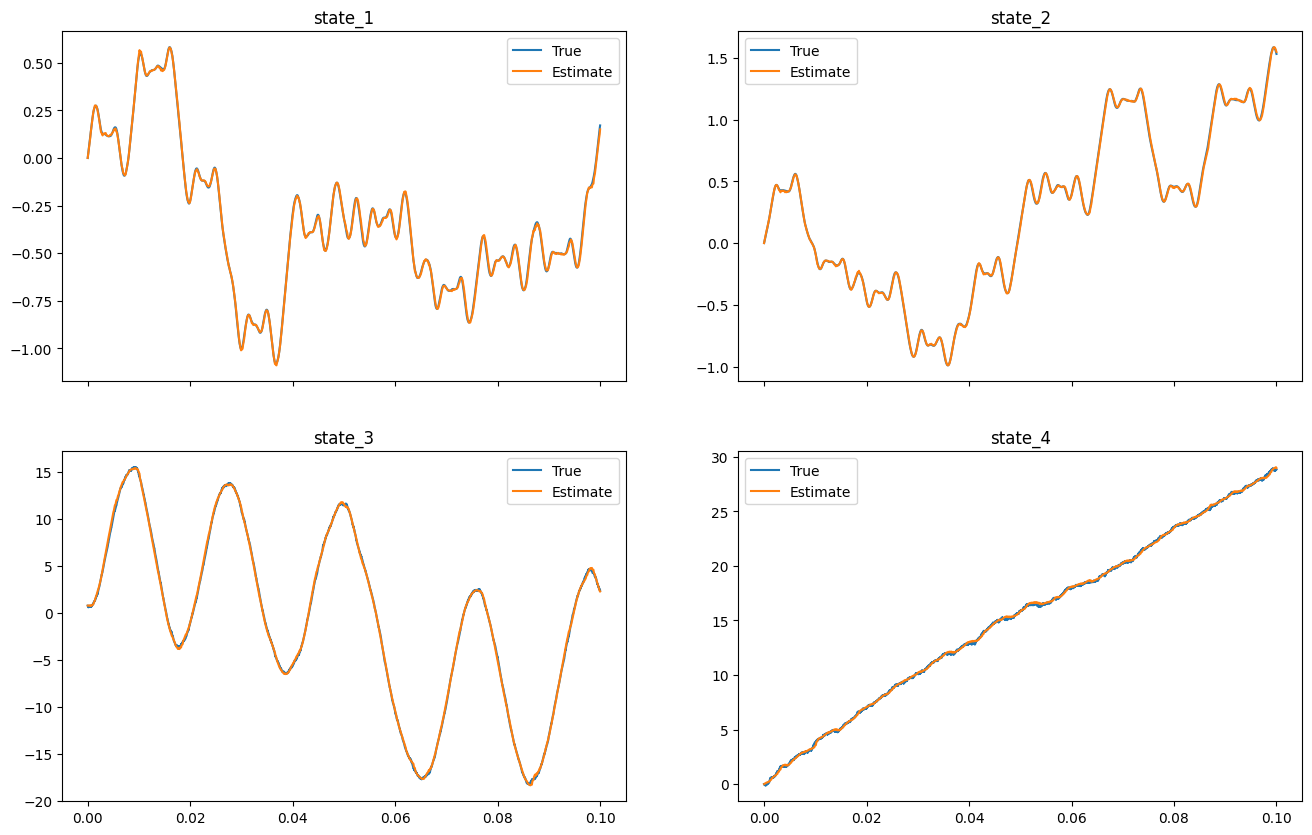

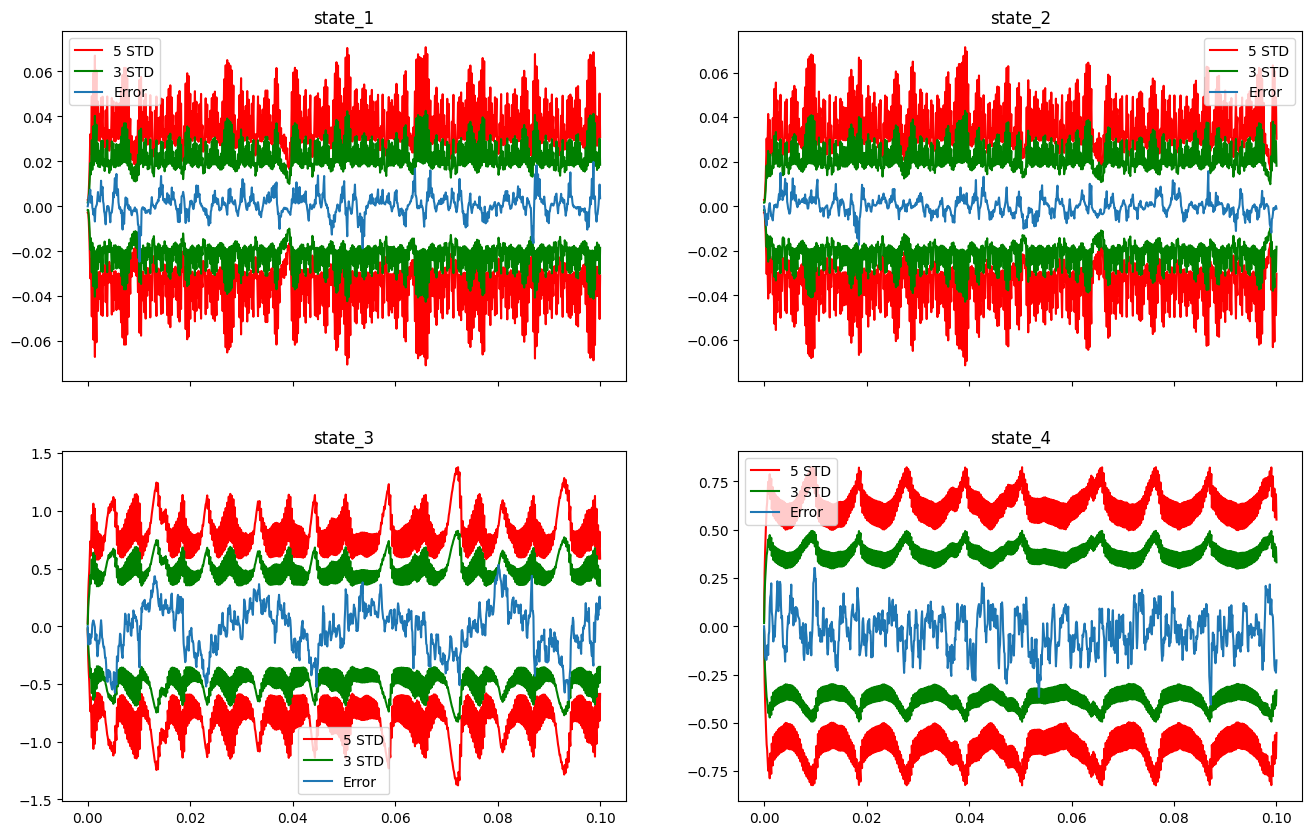

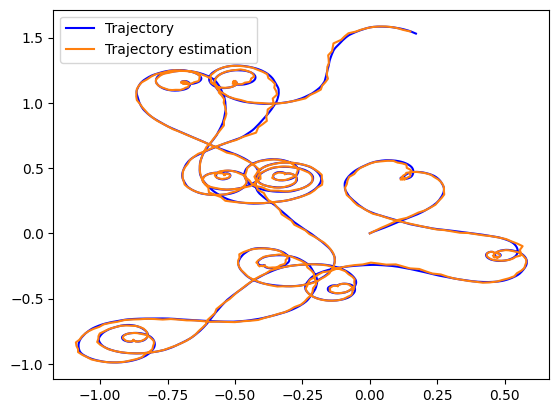

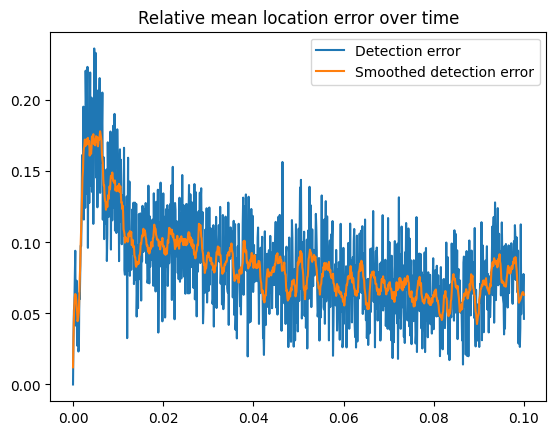

Mean smoothed relative error: 0.08500651444323927
Testing for dtype=fp64, inv_method = cholesky, update_method = joseph


100%|██████████| 9999/9999 [00:06<00:00, 1664.46it/s]


Divergence ratio: 0.001


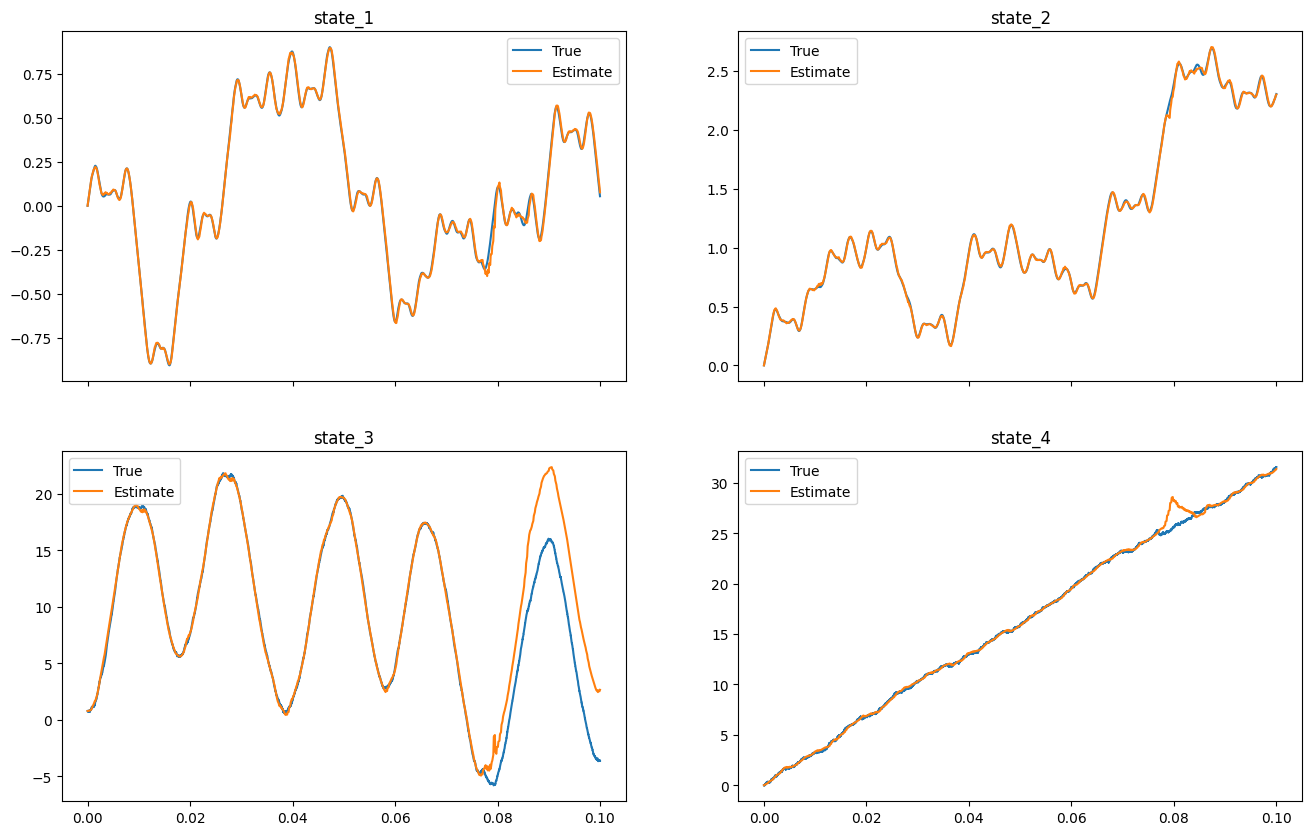

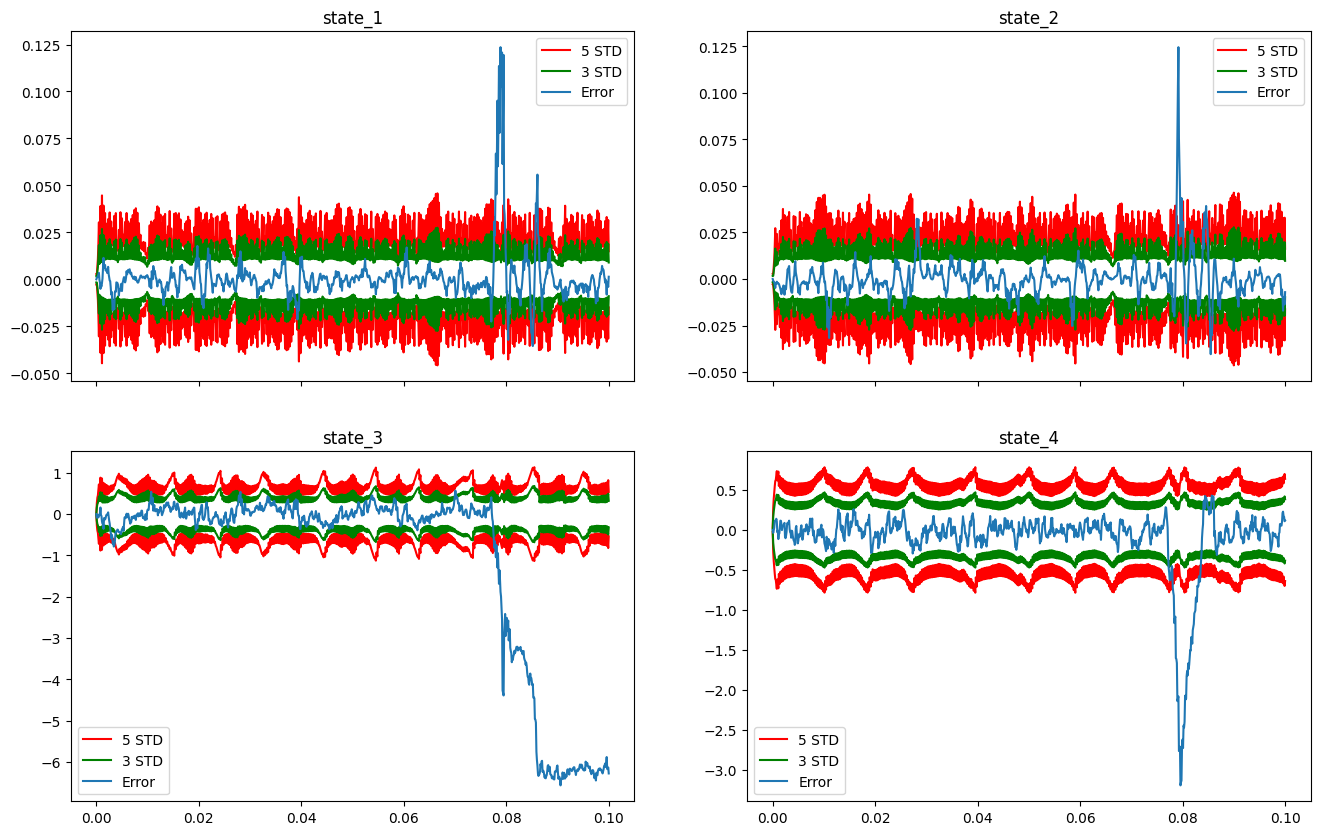

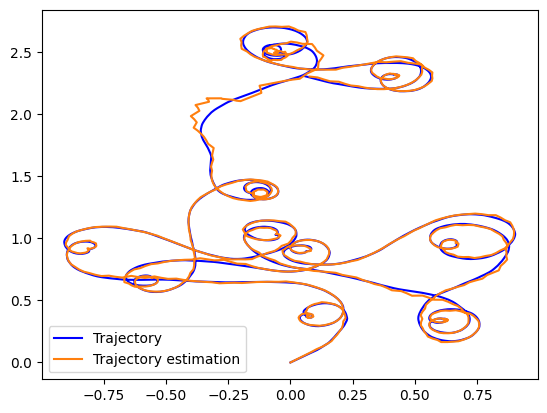

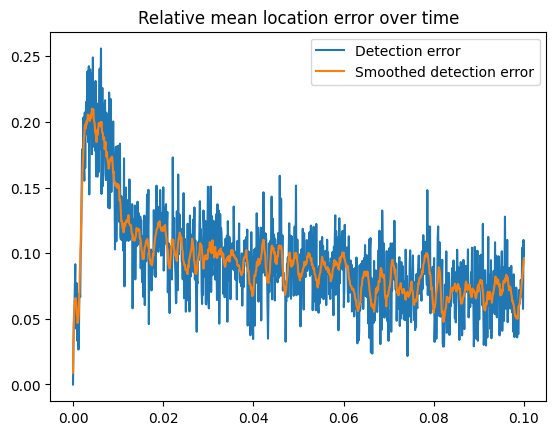

Mean smoothed relative error: 0.09437767854911264
Testing for dtype=fp32, inv_method = cholesky, update_method = classic


100%|██████████| 9999/9999 [00:06<00:00, 1652.36it/s]


Divergence ratio: 0.005


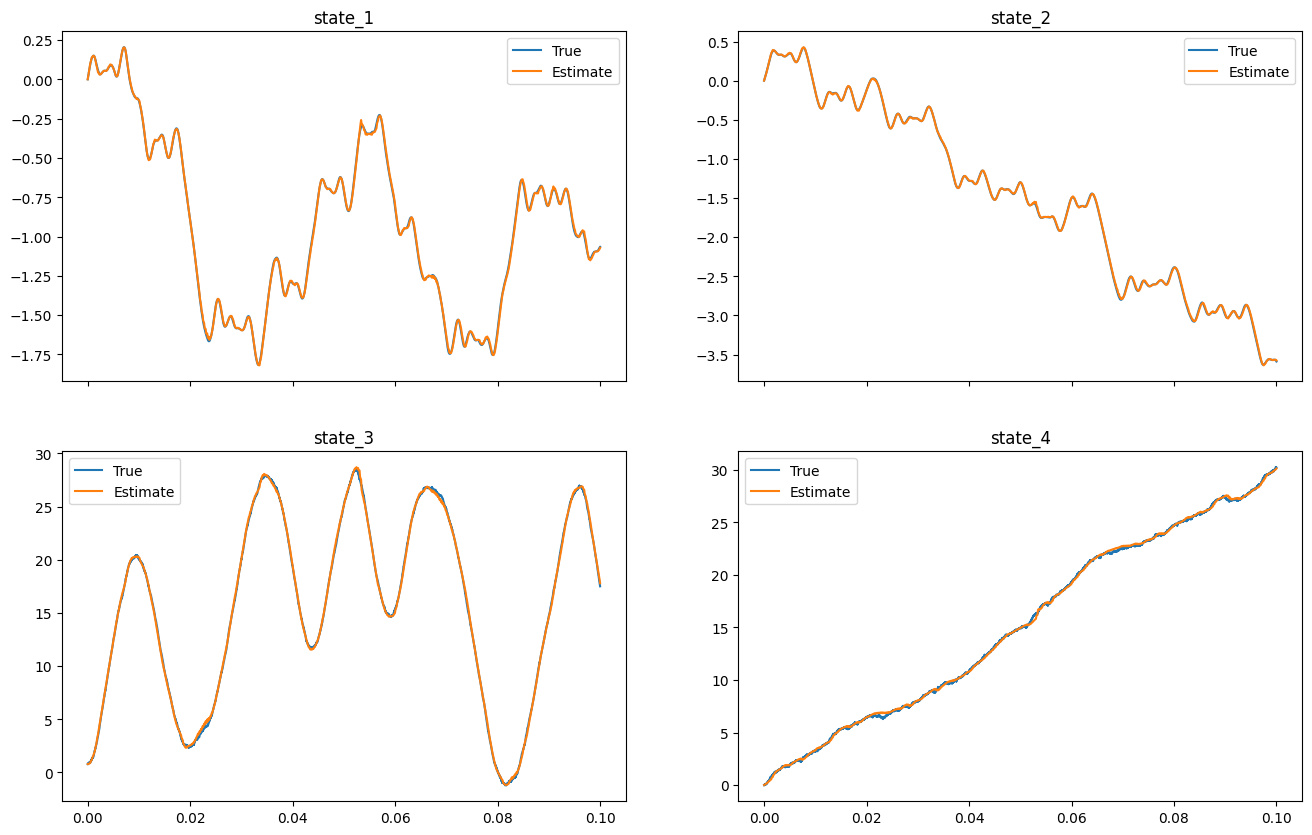

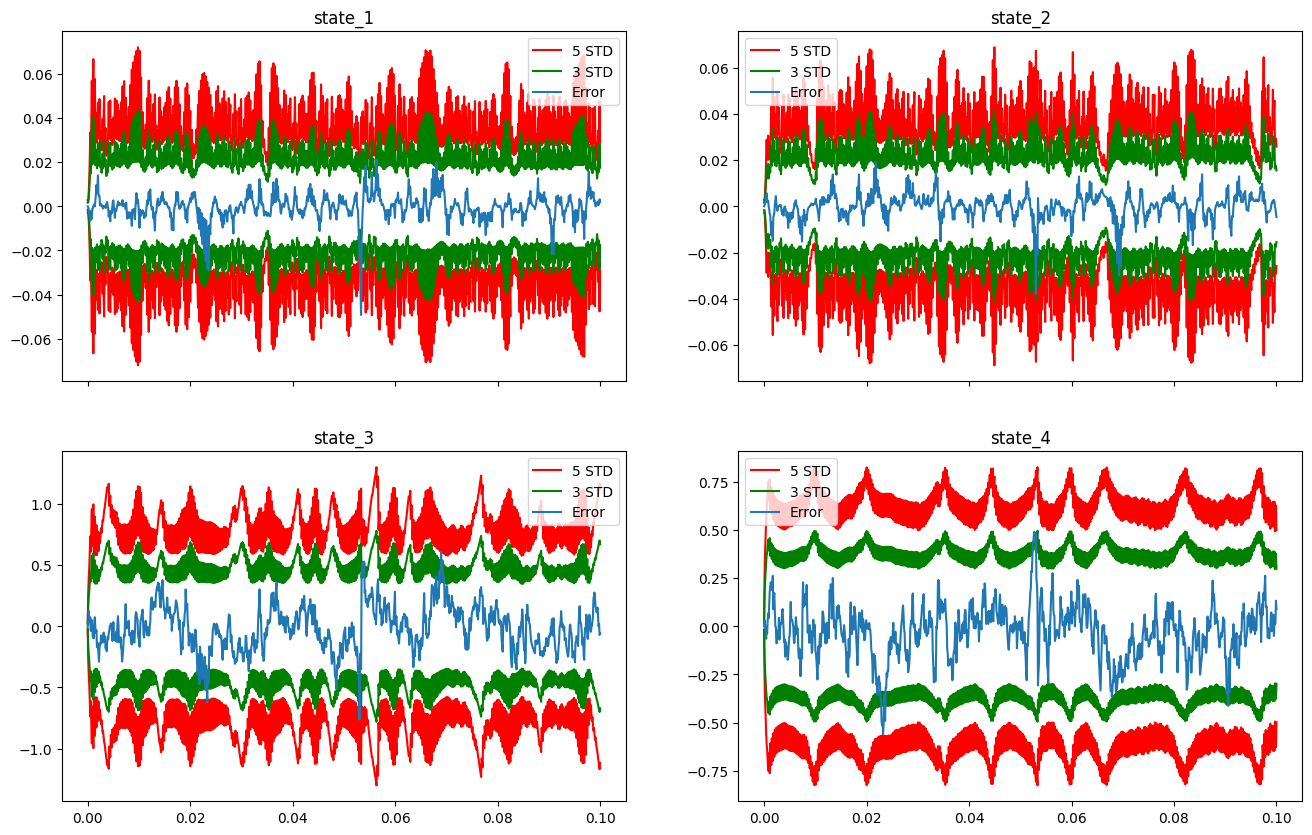

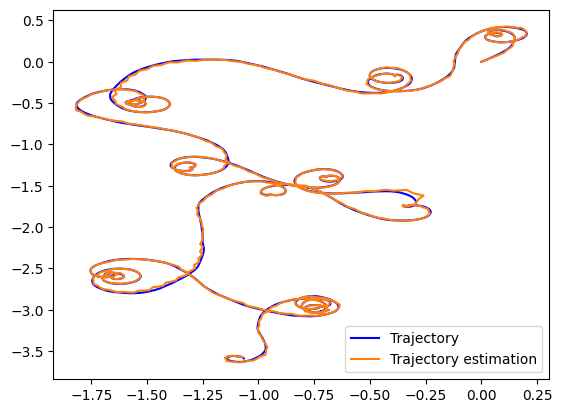

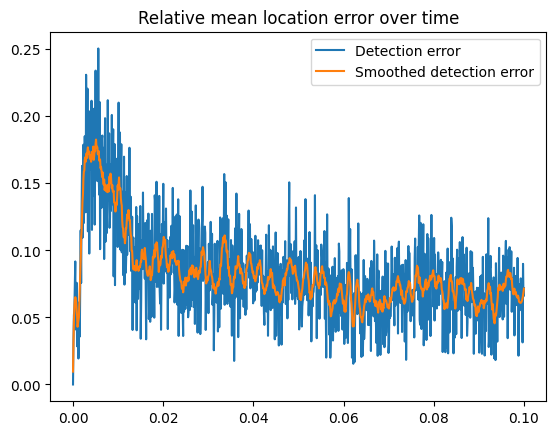

Mean smoothed relative error: 0.08344410322887946
Testing for dtype=fp32, inv_method = cholesky, update_method = joseph


100%|██████████| 9999/9999 [00:06<00:00, 1623.65it/s]


Divergence ratio: 0.002


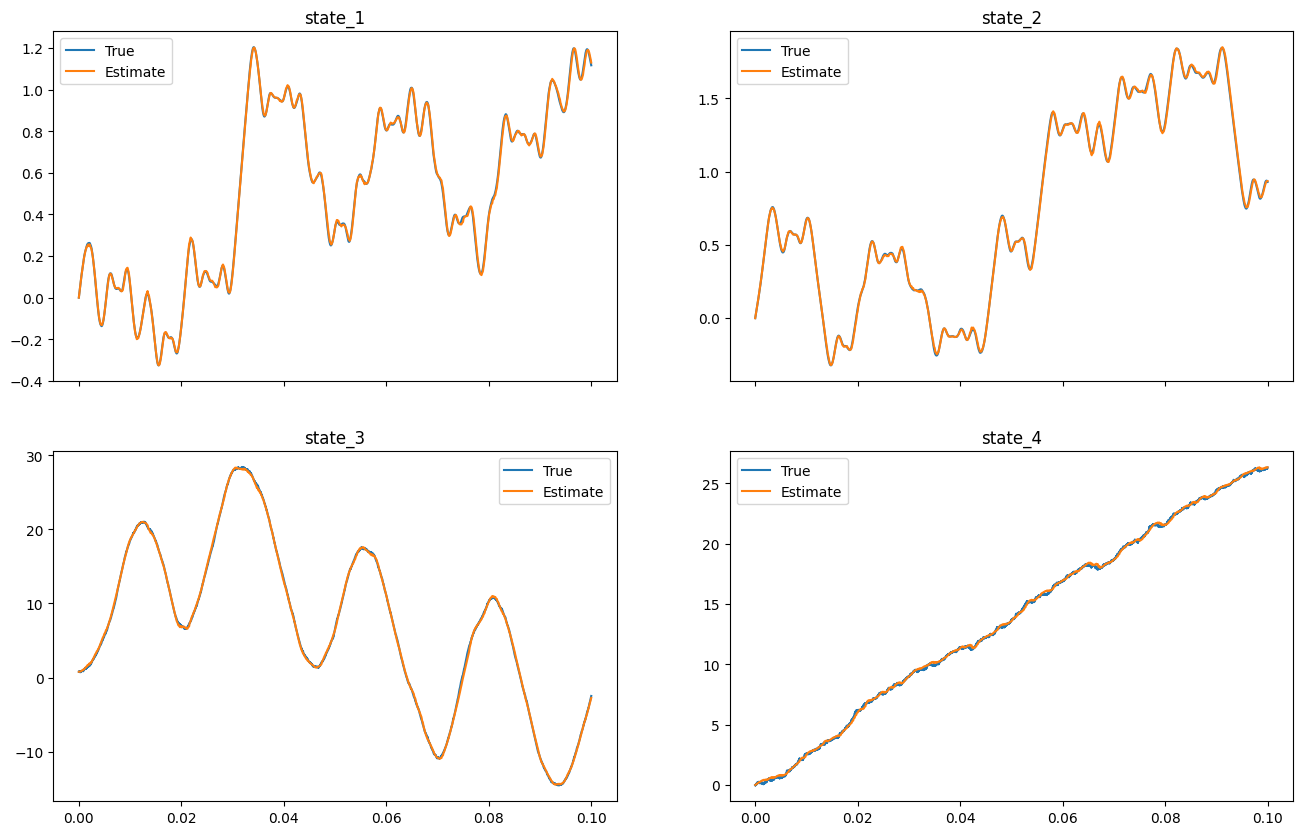

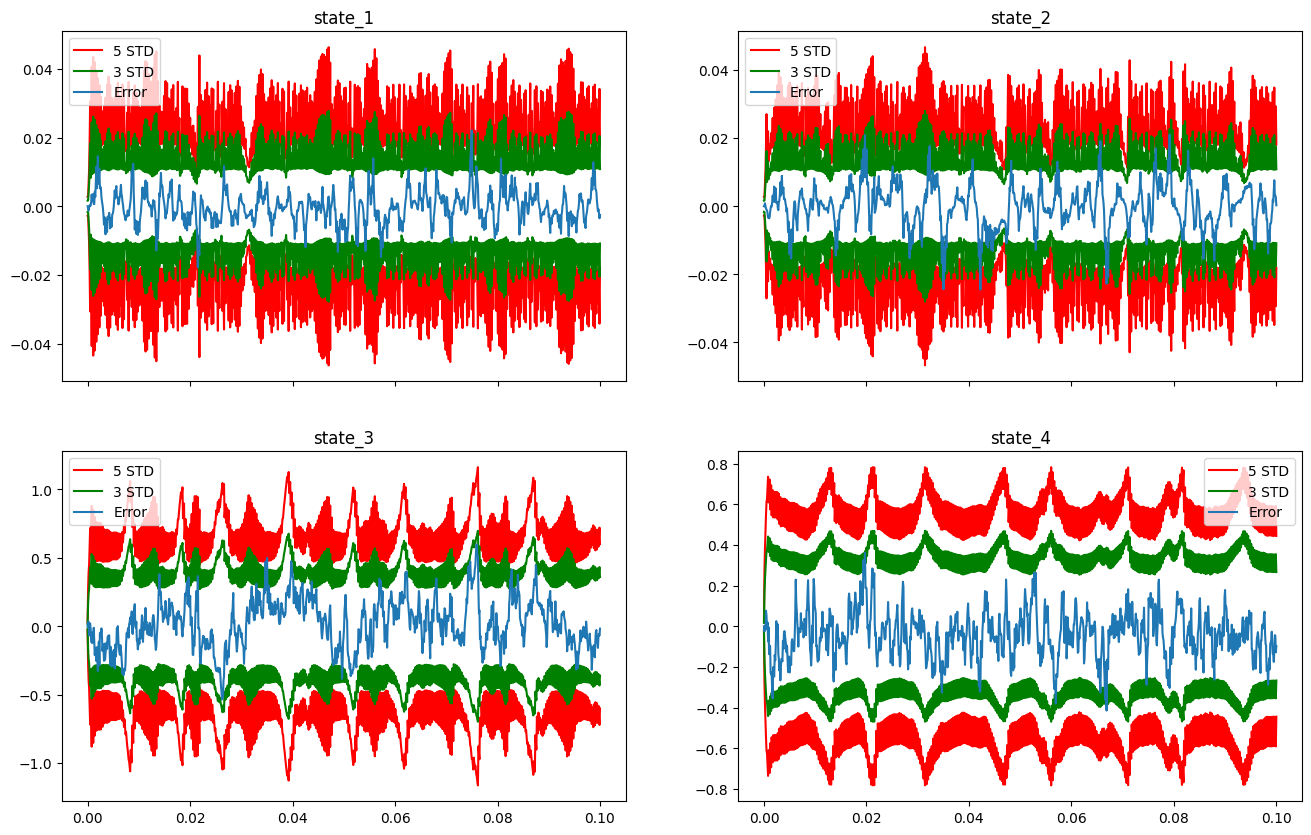

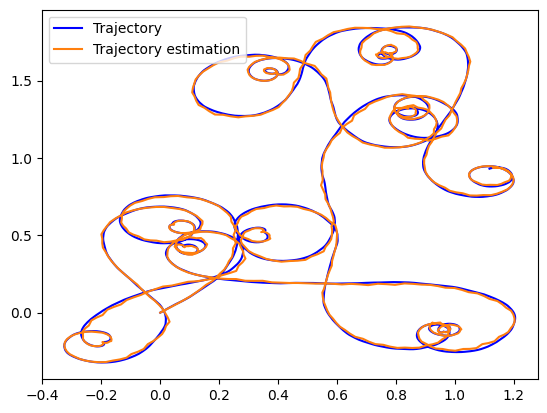

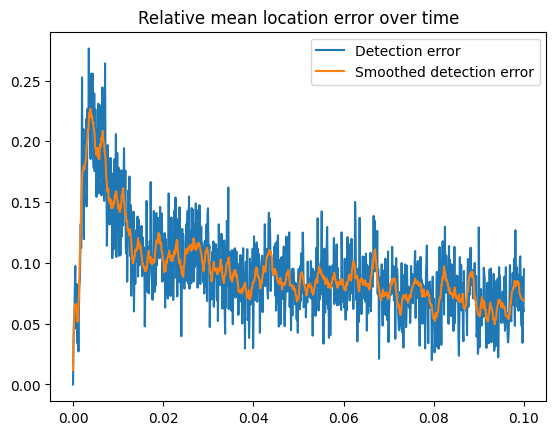

Mean smoothed relative error: 0.09453874690438667
Testing for dtype=fp16, inv_method = cholesky, update_method = classic


100%|██████████| 9999/9999 [00:06<00:00, 1617.16it/s]


Divergence ratio: 0.009


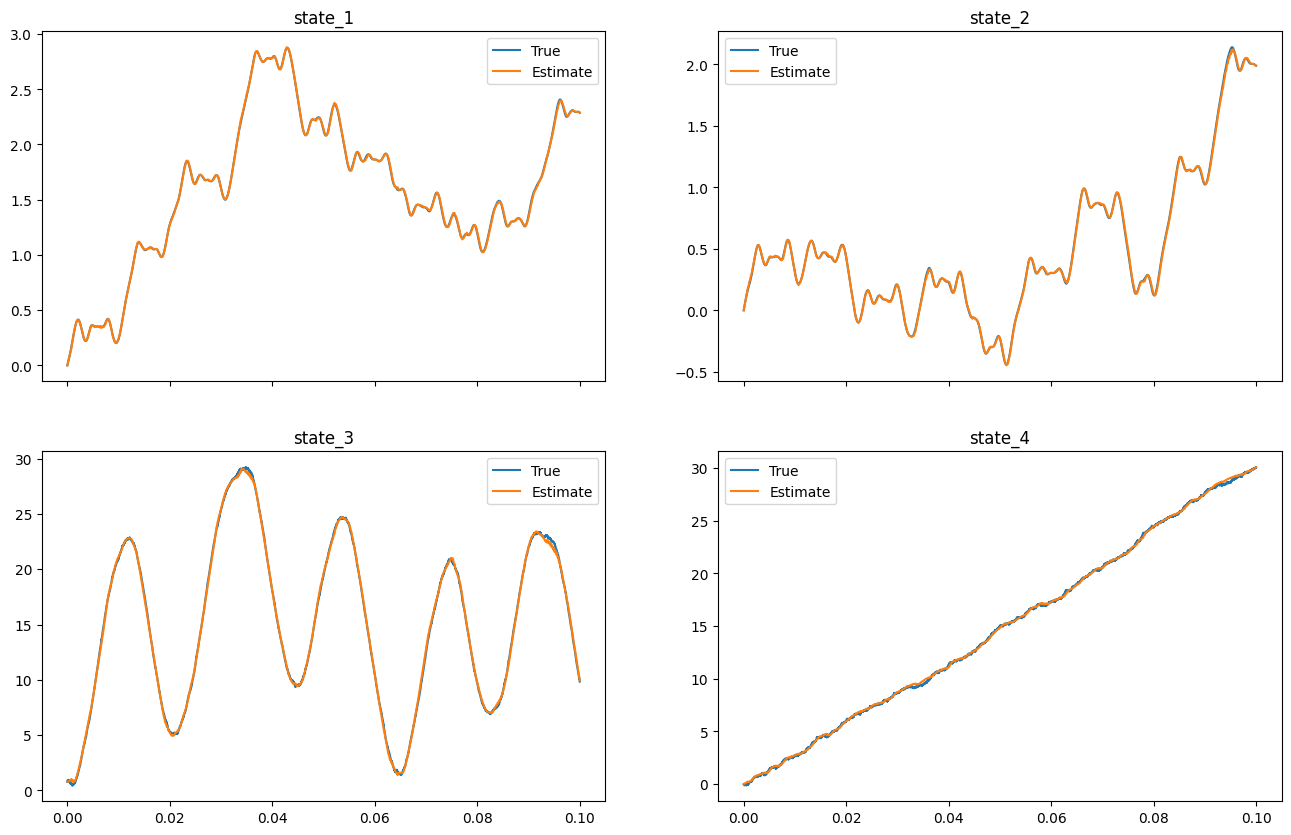

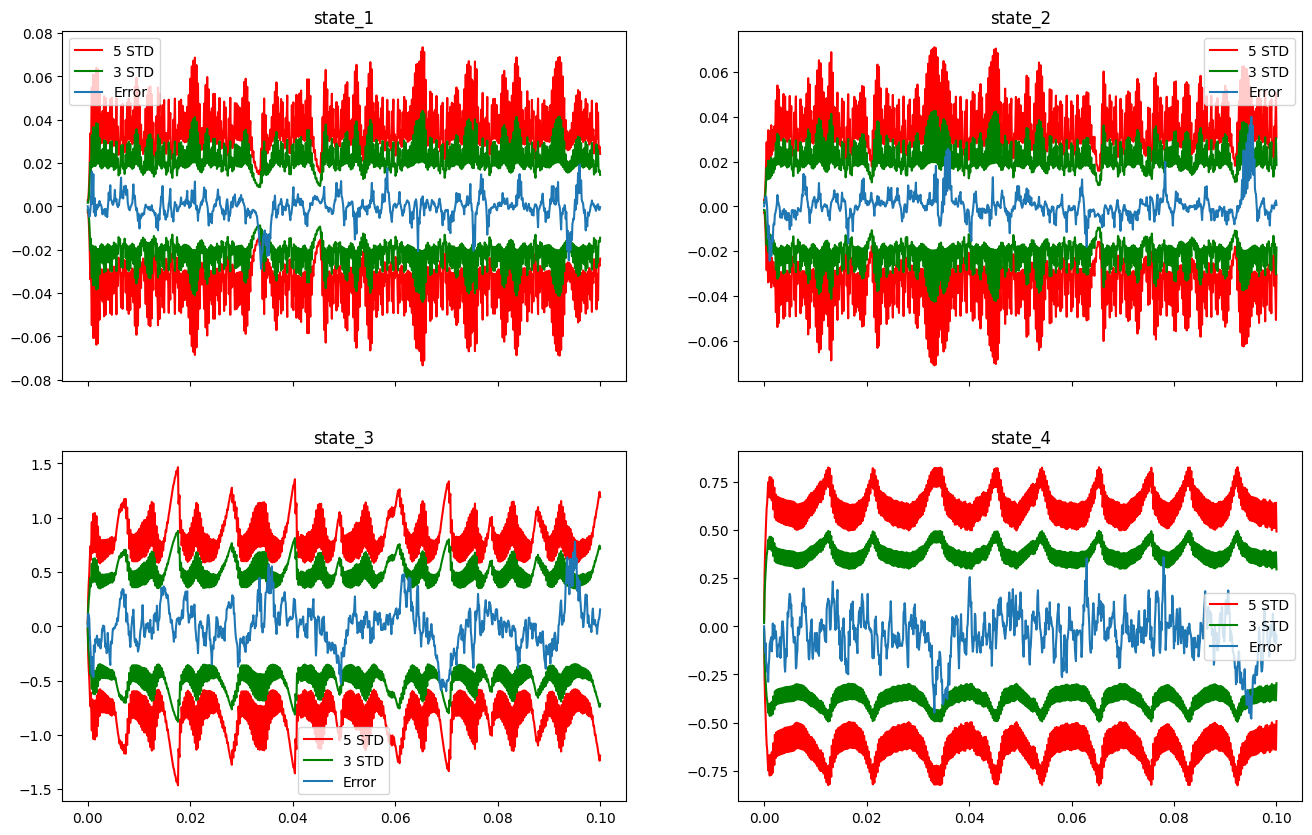

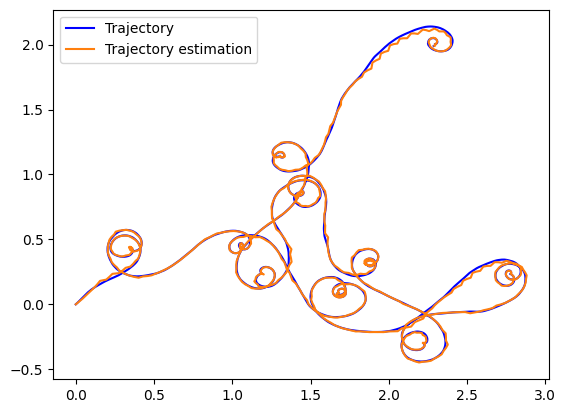

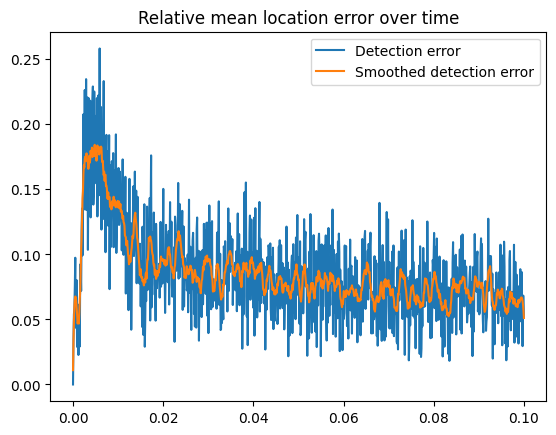

Mean smoothed relative error: 0.08606114180201312
Testing for dtype=fp16, inv_method = cholesky, update_method = joseph


100%|██████████| 9999/9999 [00:06<00:00, 1617.82it/s]


Divergence ratio: 0.003


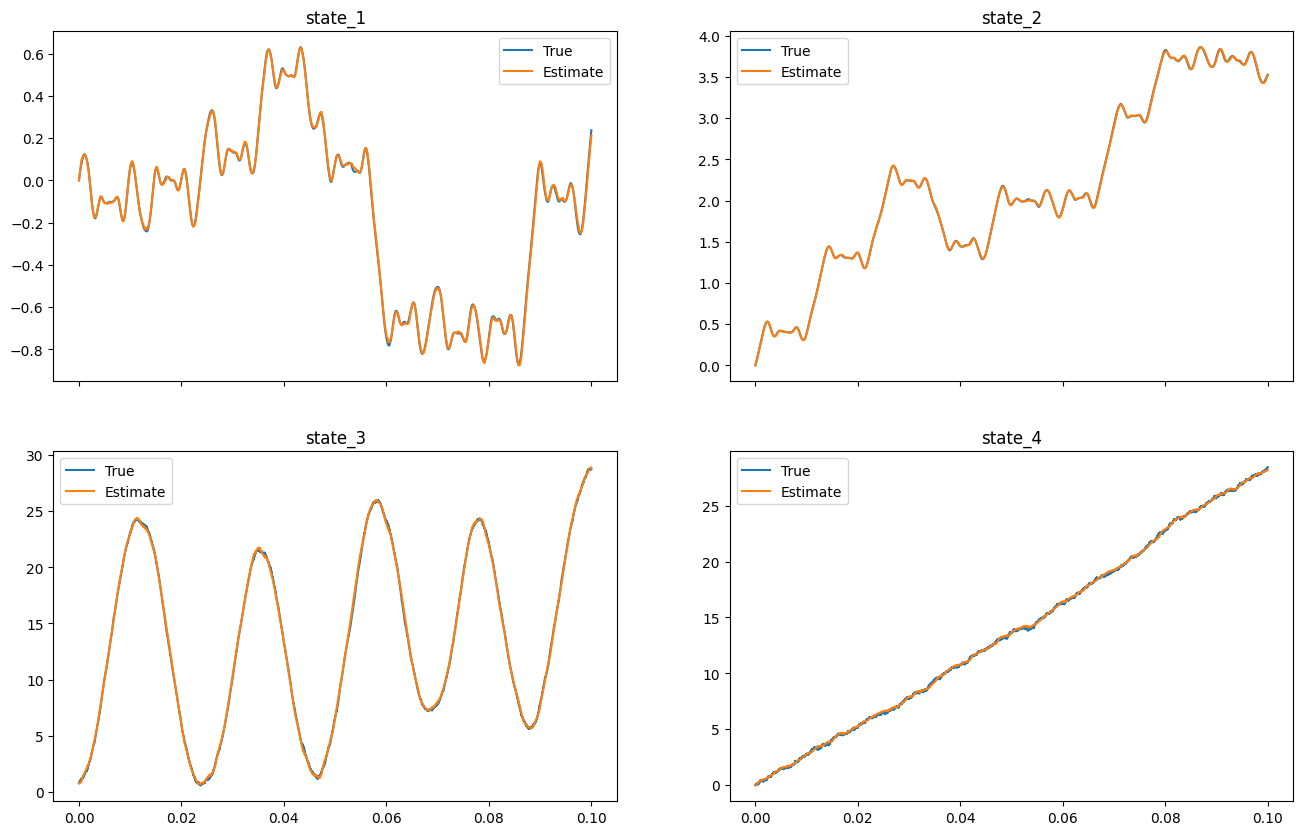

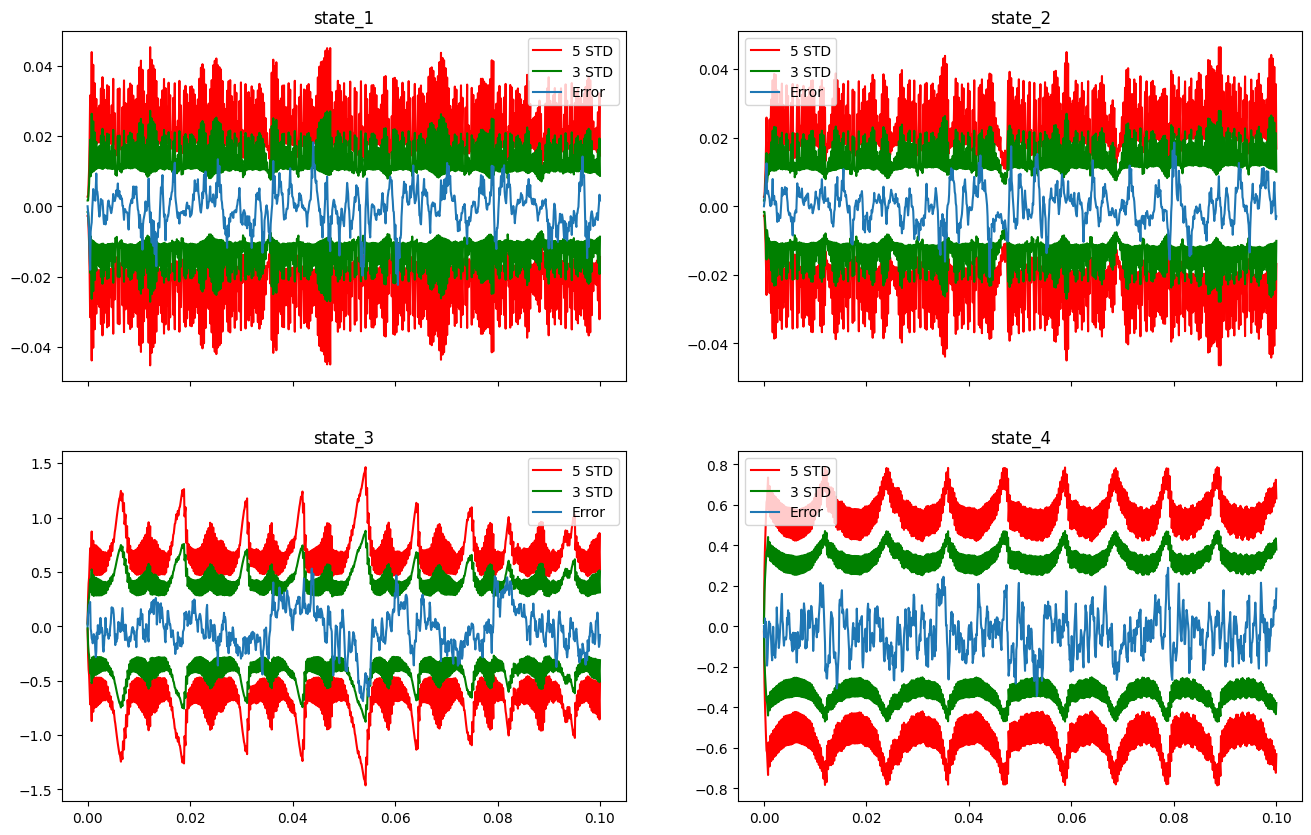

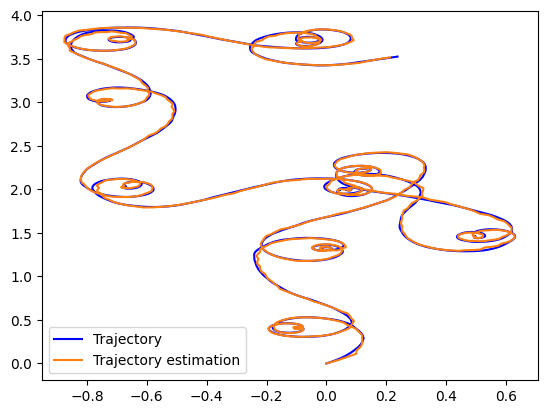

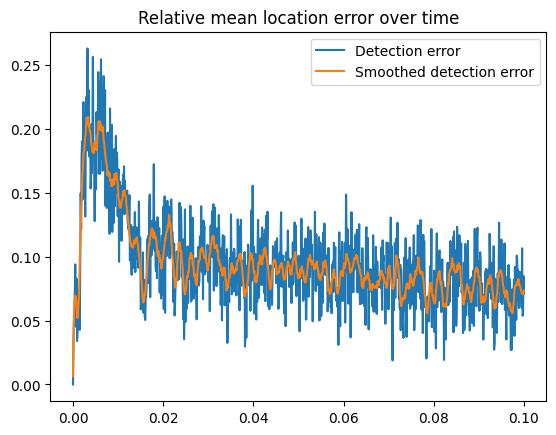

Mean smoothed relative error: 0.09565798349915385


In [20]:
data = []

with torch.no_grad():
    dtypes = [
        "fp64",
        "fp32",
        "fp16",
        # "bf16",
        # "e4m3fn",
    ]
    inv_methods = [
        # 'solve',
        # 'svd',
        # 'inv',
        # 'qr',
        "cholesky",
    ]
    update_methods = [
        'classic',
        'joseph',
    ]
    for dtype_s, inv_method, update_method in product(dtypes, inv_methods, update_methods):
        print(f'Testing for dtype={dtype_s}, inv_method = {inv_method}, update_method = {update_method}')
        match dtype_s:
            case 'fp64':
                dtype = torch.float64
            case 'fp32':
                dtype = torch.float32
            case 'fp16':
                dtype = torch.float16
            case 'bf16':
                dtype = torch.bfloat16
            case 'e4m3fn':
                dtype = torch.float8_e4m3fn
            case _:
                raise ValueError(f"Invalid type: {dtype_s}")

        traj, traj_est, traj_cov = estimate(dtype, inv_method, update_method)
        result, err_auc = convergence(traj, traj_est, traj_cov)
        data.append({'dtype': dtype_s, 'inv_method': inv_method, 'divergence': result, 'err_mean': err_auc})

df = pd.DataFrame(data)

In [21]:
df.to_csv('results.csv', index=False)